In [2]:
# Import libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_columns', 1000)

# for changing bar height
def change_height(ax, new_value) :
    for patch in ax.patches :
        current_height = patch.get_height()
        diff = current_height - new_value

        # change the bar width
        patch.set_height(new_value)

        # recenter the bar
        patch.set_x(patch.get_x() + diff * .5)

#change_width(ax, 1)

# Contents

1. Import data
2. Descriptive stats
 * not using duration because data not meaningful
3. Get datatypes
4. 

In [4]:
data_dir = 'data\\'

## 1. Import Data

In [5]:
reactions = reactions = pd.read_csv(data_dir + 'CADVR/reactions.txt', 
                            delimiter='$',
                            header = None,
                            names = ['REACTION_ID','REPORT_ID','DURATION','DURATION_UNIT_ENG','DURATION_UNIT_FR','PT_NAME_ENG','PT_NAME_FR','SOC_NAME_ENG','SOC_NAME_FR','MEDDRA_VERSION'],
                            dtype = {'REACTION_ID':'object','REPORT_ID':'object', 'PT_NAME_ENG':'category', 'SOC_NAME_ENG':'category', 'MEDDRA_VERSION':'category' })


# remove unecessary columns
# 'DURATION_UNIT_FR','PT_NAME_FR','SOC_NAME_FR',

reactions = reactions[['REACTION_ID','REPORT_ID','DURATION','DURATION_UNIT_ENG','PT_NAME_ENG','SOC_NAME_ENG','MEDDRA_VERSION']]

C:\Users\lt\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## 2. Descriptive Statistics

In [6]:
dtypes = reactions.dtypes
counts = reactions.count()
distinct_counts = reactions.nunique()

In [7]:
dstats = pd.concat([dtypes, counts, distinct_counts], axis=1)
dstats = dstats.reset_index()
dstats.columns = ['column', 'dtypes', 'counts', 'distinct_counts']
dstats

,column,dtypes,counts,distinct_counts
0,REACTION_ID,object,2606282,2606282
1,REPORT_ID,object,2606282,750583
2,DURATION,float64,85541,1593
3,DURATION_UNIT_ENG,object,75806,9
4,PT_NAME_ENG,category,2606251,11993
5,SOC_NAME_ENG,category,2606251,27
6,MEDDRA_VERSION,category,2606251,1


In [8]:
print(reactions.DURATION.min())
print(reactions.DURATION.max())

-407.0
99378.0


In [9]:
reactions.groupby('DURATION_UNIT_ENG').	DURATION.count()

DURATION_UNIT_ENG
Days       57018
Hours       1717
Minutes     1298
Months     13102
Once           0
Seconds      362
Unknown        3
Weeks        820
Years       1315
Name: DURATION, dtype: int64

In [10]:
# Do not use duration. Data not clean and not very meaningful. Report form is vague. 

reactions = reactions[['REACTION_ID','REPORT_ID','PT_NAME_ENG','SOC_NAME_ENG','MEDDRA_VERSION']]

Text(0,0.5,'System Organ Class')

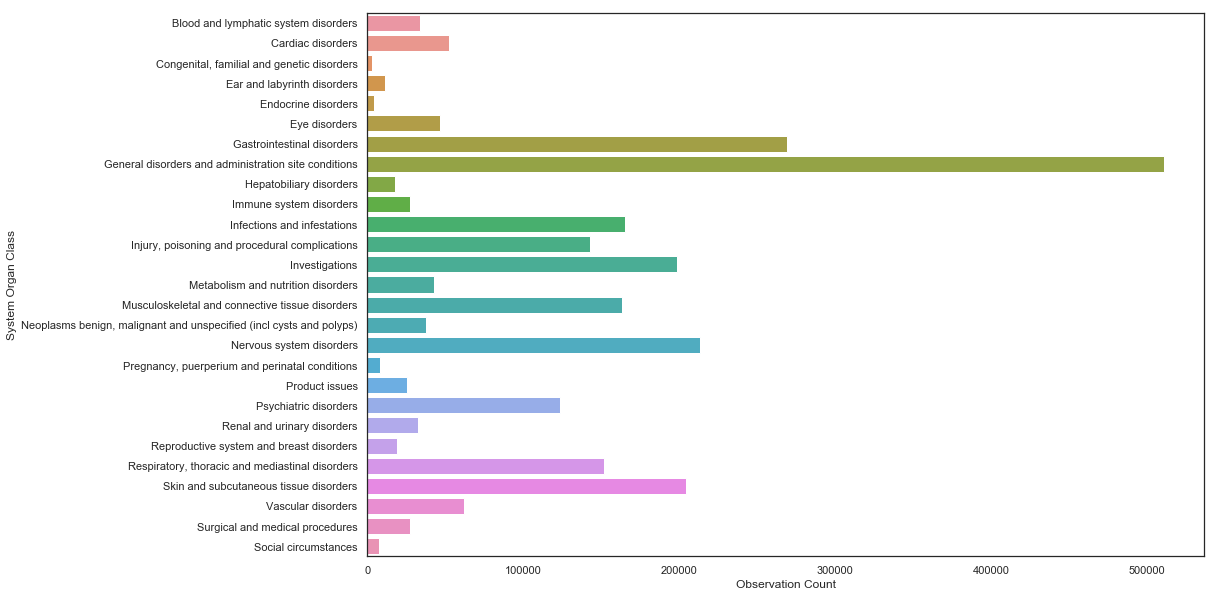

In [11]:
# Count reports by SOC

sns.set_style("white")
sns.set_context('notebook')
fig, ax = plt.subplots()
fig.set_size_inches(15,10)

ax = sns.countplot(y=reactions.SOC_NAME_ENG)
ax.set_xlabel('Observation Count')
ax.set_ylabel('System Organ Class')


### SE Terms

In [12]:
# this is supposed to contain MedDRA Preferred Terms

reactions.MEDDRA_VERSION.unique()

[v.22.1, NaN]
Categories (1, object): [v.22.1]

In [13]:
# There are 11,993 SEs in CVADR
# We need to limit to what is in SIDER

In [14]:
# load SE pairs

meddra_all_se = pd.read_csv(data_dir + 'SIDER/meddra_all_se.tsv', delimiter='\t', header=None,
                                          names=['STITCH_FLAT','STITCH_STEREO', 'UMLS_CONCEPT_ID_LABEL','MEDDRA_CONCEPT_TYPE','UMLS_CONCEPT_ID_MEDDDRA','SE'])

In [15]:
# get unique SE terms

sider_se = meddra_all_se[['MEDDRA_CONCEPT_TYPE','UMLS_CONCEPT_ID_MEDDDRA','SE']].drop_duplicates()

In [16]:
# there are only ~3000 meddra concepts

sider_se.nunique()

MEDDRA_CONCEPT_TYPE           2
UMLS_CONCEPT_ID_MEDDDRA    6060
SE                         6123
dtype: int64

In [48]:
reactions_filtered = reactions[reactions.PT_NAME_ENG.isin(sider_se.SE)]

In [49]:
reactions_filtered.count()

REACTION_ID       2254455
REPORT_ID         2254455
PT_NAME_ENG       2254455
SOC_NAME_ENG      2254455
MEDDRA_VERSION    2254455
dtype: int64

In [50]:
# remove duplcate reactions from each report

reactions_filtered_dedup = reactions_filtered.drop_duplicates(subset=['REPORT_ID','PT_NAME_ENG','SOC_NAME_ENG'])

In [51]:
# reactions data before and after filtering for MedDRA concepts in SIDER

filtered_reaction_stats = pd.concat([reactions.nunique(),reactions_filtered.nunique()], axis=1)
filtered_reaction_stats.columns = ['original', 'filtered']
filtered_reaction_stats['percent_filtered'] = filtered_reaction_stats['filtered']/filtered_reaction_stats['original']
filtered_reaction_stats

,original,filtered,percent_filtered
REACTION_ID,2606282,2254455,0.865008
REPORT_ID,750583,713703,0.950865
PT_NAME_ENG,11993,3904,0.325523
SOC_NAME_ENG,27,27,1.000000
MEDDRA_VERSION,1,1,1.000000


In [52]:
# count of reports by SE
side_effect_count = reactions_filtered.groupby('PT_NAME_ENG')['REPORT_ID'].count().reset_index().sort_values(by='REPORT_ID', ascending=False)
side_effect_count.columns = ['side_effect', 'report_count']
side_effect_count = side_effect_count[side_effect_count['report_count'] != 0]

In [53]:
side_effect_count

,side_effect,report_count
279,Drug ineffective,119373
638,Nausea,42586
794,Rash,35591
772,Pruritus,34198
359,Fatigue,33481
...,...,...
7766,Application site anaesthesia,1
10700,Tracheostomy infection,1
2484,Aplasia cutis congenita,1
11974,Malignant transformation,1


In [54]:
# count of SE be SOC

se_count_by_soc = reactions_filtered.groupby('SOC_NAME_ENG')['PT_NAME_ENG'].nunique().sort_values(ascending=False).reset_index()
se_count_by_soc.columns = ['soc','se_count']


In [55]:
se_count_by_soc

,soc,se_count
0,Infections and infestations,359
1,Investigations,323
2,Nervous system disorders,301
3,Gastrointestinal disorders,280
4,General disorders and administration site cond...,239
5,Eye disorders,216
6,"Neoplasms benign, malignant and unspecified (i...",206
7,Skin and subcutaneous tissue disorders,203
8,"Injury, poisoning and procedural complications",184
9,Reproductive system and breast disorders,182


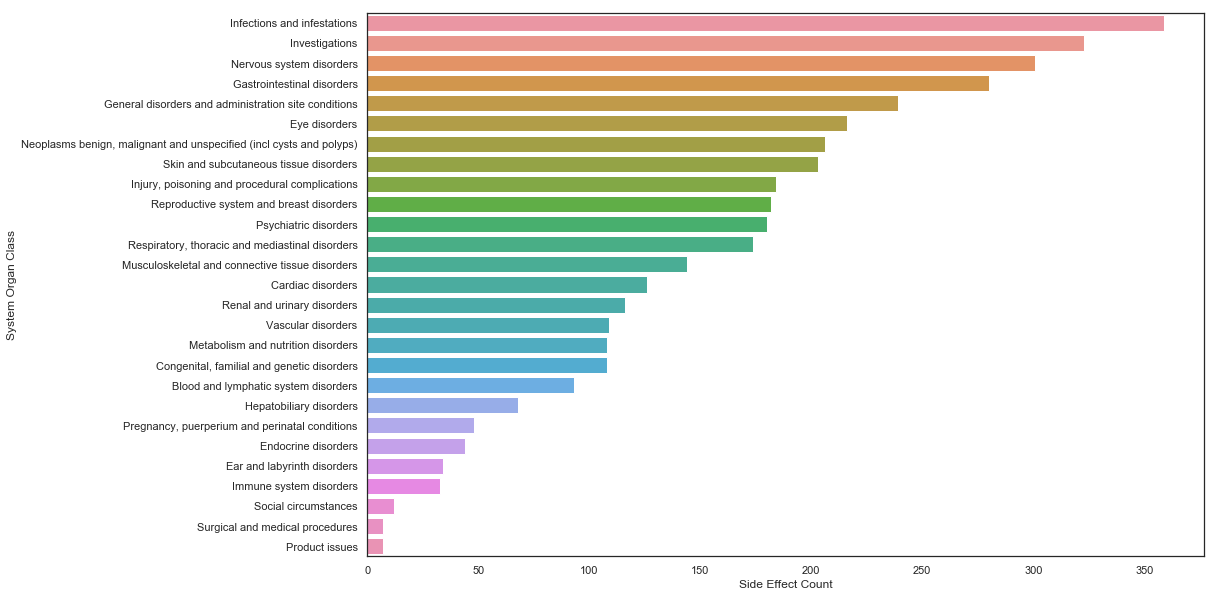

In [56]:
sns.set_style("white")
sns.set_context('notebook')
fig, ax = plt.subplots()
fig.set_size_inches(15,10)

ax = sns.barplot(data=se_count_by_soc, y='soc', x='se_count', order=se_count_by_soc.soc)
ax.set_xlabel('Side Effect Count')
ax.set_ylabel('System Organ Class')

plt.show()

In [68]:
# count of SE by report

se_count_by_report = reactions_filtered_dedup.groupby('REPORT_ID')['PT_NAME_ENG','SOC_NAME_ENG'].count().sort_values(by='PT_NAME_ENG',ascending=True).reset_index()
se_count_by_report.tail(10)

,REPORT_ID,PT_NAME_ENG,SOC_NAME_ENG
713693,901499992,82,82
713694,901425606,82,82
713695,900392005,82,82
713696,470954,85,85
713697,902706836,87,87
713698,901196891,88,88
713699,337926,91,91
713700,900576831,96,96
713701,901310074,111,111
713702,902642787,111,111


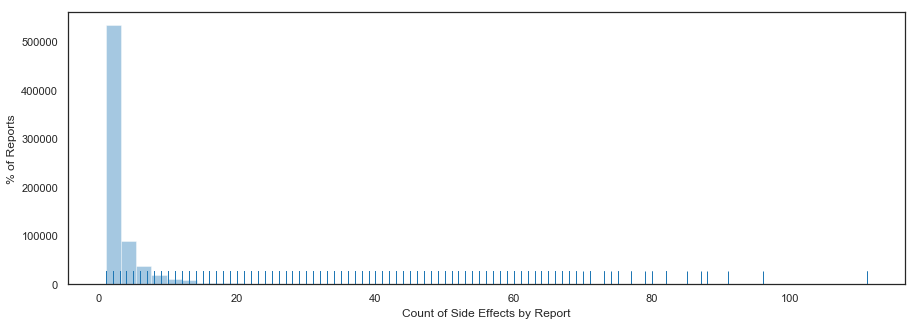

In [69]:
sns.set_style("white")
sns.set_context('notebook')
fig, ax = plt.subplots()
fig.set_size_inches(15,5)

ax = sns.distplot(se_count_by_report.PT_NAME_ENG, kde=False, rug=True)
ax.set_xlabel('Count of Side Effects by Report')
ax.set_ylabel('% of Reports')

plt.show()

In [70]:
# Some reports have a ridiculous number of reactions. Should probably remove these because they are non-specific. 

print(list(reactions[reactions['REPORT_ID']=='901196891'].PT_NAME_ENG))

['Mood altered', 'Visual impairment', 'Swelling', 'Sensory disturbance', 'Balance disorder', 'Hypoaesthesia', 'Vision blurred', 'Menstruation irregular', 'Menorrhagia', 'Acne', 'Pain', 'Erythema', 'Fatigue', 'Hot flush', 'Decreased appetite', 'Pain in extremity', 'Pain in extremity', 'Anxiety', 'Peripheral swelling', 'Gastrointestinal disorder', 'Paraesthesia oral', 'Back pain', 'Dysuria', 'Paraesthesia', 'Rhinorrhoea', 'Poor quality sleep', 'Urine abnormality', 'Palpitations', 'Hyperhidrosis', 'Gait disturbance', 'Throat irritation', 'Feeling cold', 'Weight decreased', 'Muscle spasms', 'Hyperhidrosis', 'Tremor', 'Initial insomnia', 'Bacterial test positive', 'Abdominal discomfort', 'Neutropenia', 'Vitreous floaters', 'Breast inflammation', 'Visual impairment', 'Vitamin D decreased', 'Discomfort', 'Paraesthesia', 'Sensory loss', 'Muscle tightness', 'Varicose vein', 'Chest pain', 'Eye irritation', 'Panic attack', 'Confusional state', 'Epistaxis', 'Feeling hot', 'Photophobia', 'Hypoacusi

In [60]:
se_count_by_report.PT_NAME_ENG.quantile([.1,.2,.3,.4,.5,.6,.7,.8,.9,.99,.999,.9999])

0.1000     1.0
0.2000     1.0
0.3000     1.0
0.4000     1.0
0.5000     2.0
0.6000     2.0
0.7000     3.0
0.8000     4.0
0.9000     6.0
0.9900    20.0
0.9990    41.0
0.9999    65.0
Name: PT_NAME_ENG, dtype: float64

In [61]:
se_count_by_report[se_count_by_report.PT_NAME_ENG > 20].count()

REPORT_ID      6690
PT_NAME_ENG    6690
dtype: int64

In [62]:
se_count_by_report[se_count_by_report.PT_NAME_ENG <= 20].count()

REPORT_ID      707013
PT_NAME_ENG    707013
dtype: int64

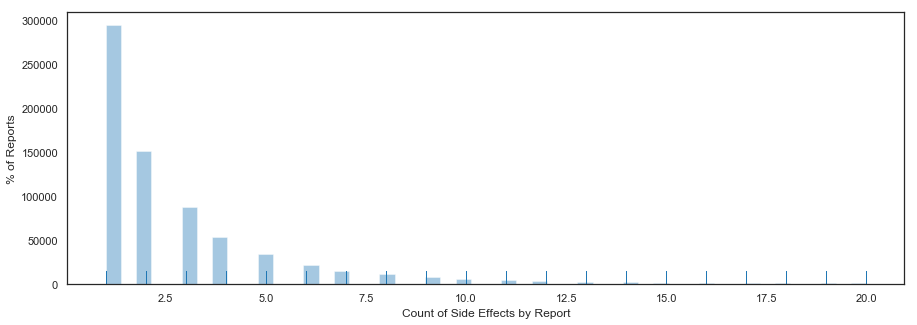

In [72]:
sns.set_style("white")
sns.set_context('notebook')
fig, ax = plt.subplots()
fig.set_size_inches(15,5)

se_count_by_report_2 = se_count_by_report[se_count_by_report.PT_NAME_ENG <= 20]
ax = sns.distplot(se_count_by_report_2.PT_NAME_ENG, kde=False, rug=True)
ax.set_xlabel('Count of Side Effects by Report')
ax.set_ylabel('% of Reports')

plt.show()

In [ ]:
sns.jointplot(x='PT_NAME_ENG', y='SOC_NAME_ENG', data=se_count_by_report_2);

In [77]:
# add filtered desc stats to summary table
filtered_counts = reactions_filtered_2.count()
filtered_distinct_counts = reactions_filtered_2.nunique()

In [85]:
filtered_counts

REACTION_ID       2050128
REPORT_ID         2050128
PT_NAME_ENG       2050128
SOC_NAME_ENG      2050128
MEDDRA_VERSION    2050128
dtype: int64

In [88]:
filtered_distinct_counts

REACTION_ID       2050128
REPORT_ID          707013
PT_NAME_ENG          3892
SOC_NAME_ENG           27
MEDDRA_VERSION          1
dtype: int64

In [89]:
dstats


,column,dtypes,counts,distinct_counts,filtered_counts,filtered_distinct_counts
0,REACTION_ID,object,2606282,2606282,NaN,NaN
1,REPORT_ID,object,2606282,750583,NaN,NaN
2,DURATION,float64,85541,1593,NaN,NaN
3,DURATION_UNIT_ENG,object,75806,9,NaN,NaN
4,PT_NAME_ENG,category,2606251,11993,NaN,NaN
5,SOC_NAME_ENG,category,2606251,27,NaN,NaN
6,MEDDRA_VERSION,category,2606251,1,NaN,NaN


In [90]:
reactions_filtered_2.columns.values

array(['REACTION_ID', 'REPORT_ID', 'PT_NAME_ENG', 'SOC_NAME_ENG',
       'MEDDRA_VERSION'], dtype=object)

In [92]:
# export to csv 
reactions_filtered_2[['REACTION_ID', 'REPORT_ID', 'PT_NAME_ENG', 'SOC_NAME_ENG']].to_csv(data_dir + 'CADVR/processed_reactions.csv', index=False)